# Multilayer Perceptron (MLP) for Classifying Wafer Bin Maps Pattern Defects Based on WM-811k dataset

This code will show the steps on classifying WBM images using MLP and WM-811k dataset based on eight classes that represent eight defect patterns, namely, center, donut, edge-loc, edge-ring, loc, near-full, random, and scratch as shown in figure below. 

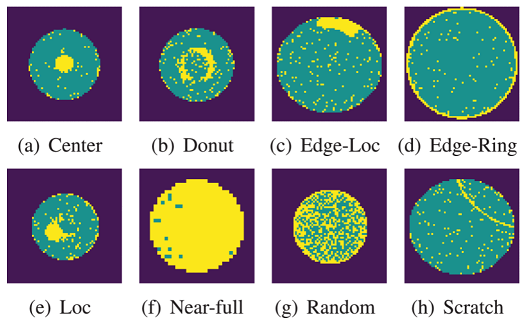

The original dataset contains around 24k labelled data for the eight classes; however, the data used here were upsampled using DCGAN (see the link for [DCGAN code](https://github.com/abuebayyeh/waferDCGAN)) such that the new data will contain the original 24k samples and DCGAN generated data. The new combined dataset has 80k samples and were divided into three folders: train, validate, and test. The test folder contains original samples only, while the train and validate contain mixed dataset. 

General notes about the code before we start:

- This code is part of the codes implemented in the following paper: [An Improved Capsule Network (WaferCaps) for Wafer Bin Map Classification Based on DCGAN Data Upsampling](https://ieeexplore.ieee.org/document/9646243). Please feel free to cite our paper if you found the code useful for your research :)


## Brief Introduction to MLP

Multilayer perceptron (MLP) networks are one of the most commonly used networks, they are also considered as feed-forward networks. The development of back-propagation learning algorithm for determining weights and biases was the main reason behind the popularity of these networks among researchers. The basic building block of this type of networks is called Perceptron. The perceptron takes one or more inputs that go through specific activation function in a neuron to produce an output, for example the perceptron has $n$ inputs that goes inside a neuron and produces an output $y$ as shown in Figure below.

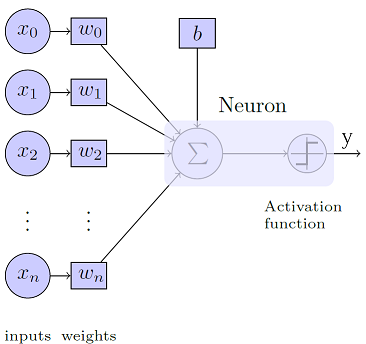

Rosenblatt proposed simple yet effective rules to compute the output by introducing weights; weights are real numbers the describe the importance of each input to the system, in which the input with less importance will be penalized by multiplying it with low or in some cases zero weight, on the other hand the inputs that have high influence on the system will be rewarded by multiplying them with relatively high weights. Activation function (e.g. sigmoid function, tanh, or ReLU) is used to add non-linearity to the process and help in decision making, applying the activation function takes place after multiplying the weights with the inputs.

As the name suggests, MLP is consisted of multi-perceptron in order to deal with complex problem, the general topology of this network is shown in figure below which represent a 2-layer MLP (hence: the input layer is not counted as a layer).


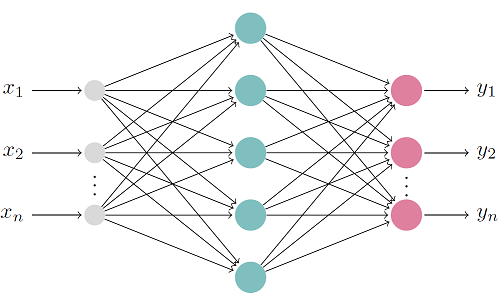



The outputs of each layer from the perceptron are fed to the next layer as inputs and so on until final layer is reached, this process is called feedforward process. In order for the MLP to work efficiently it has to be trained, this can be performed by relying on the historical data (training data) for the inputs and corresponding outputs. Ideally, if the inputs from the historical data were fed to the MLP, the same corresponding outputs from the historical data have to be obtained. Therefore, a sort of comparison process has to be established between the actual outputs of the network and real outputs from the historical data to have a sense of the error. This comparison can be made by using cost function (e.g. MSE). After the cost function is defined, the weights and biases of the MLP has to be updated until to the cost function reaches a minimal value. In order to do so, partial derivative is used to track the change of cost function with respect to the weights and biases. The process of getting the optimum weight that corresponds to minimal error is called Gradient Descent. This step begins from the output layer until the error is investigated at the input layer which justify the name \textit{backpropagation} for this process. 

MLPs are usually described according to the number of neurons and layers used. For example, a 3-5-4 MLP means that this is a two-layer network that consists of input layer with three inputs, hidden layer with five neurons and output layer with four outputs.

## Our MLP for WM-811k Data

Before the images are fed to the MLP, they should go the image should be transformed to vector format since MLP can only receive the input data in vector form. [Hence step is necessary when we are dealing with the CNN classification](https://github.com/abuebayyeh/waferCNN)

The WM-811k images we are dealing with are of size $64 \times 64$ each. Therefore, in order to feed the input data to the MLP, an image of size $64 \times 64$ will be transformed to a vector of size $[4096,]$.In this tutorial we will build the $4096-128-128-128-8$ MLP shown in the figure below.

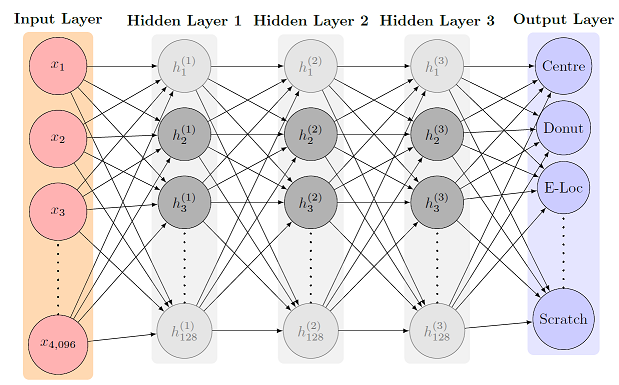

##### Enough talking and lets do some coding :) 
First we will import the packages we want to use in the code as shown below

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
from sklearn.utils import shuffle
import sklearn.metrics as metrics
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Here we define the paths for the training and validation data. Henece, we will leave the test data for later.

The data are organised in one main folder that contains three subfolders (Train, Validate, and Test). Each subfolder of these contains eight subfolders named after the classes (Center, Donut, Edge-Loc, Edge-Ring, Loc, Near-full, Random, and Scratch).

In [2]:
base_dir = 'WM811k(TTV)'
train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validate')

In [3]:
# Define the directory for each class in the traning dataset.
train_Center_dir = os.path.join(train_dir, 'Center\*.png')
train_Donut_dir = os.path.join(train_dir, 'Donut\*.png')
train_Edge_Loc_dir = os.path.join(train_dir, 'Edge-Loc\*.png')
train_Edge_Ring_dir = os.path.join(train_dir, 'Edge-Ring\*.png')
train_Loc_dir = os.path.join(train_dir, 'Loc\*.png')
train_Near_full_dir = os.path.join(train_dir, 'Near-full\*.png')
train_Random_dir = os.path.join(train_dir, 'Random\*.png')
train_Scratch_dir = os.path.join(train_dir, 'Scratch\*.png')

# Define the directory for each class in the validation dataset.
validation_Center_dir = os.path.join(validation_dir, 'Center\*.png')
validation_Donut_dir = os.path.join(validation_dir, 'Donut\*.png')
validation_Edge_Loc_dir = os.path.join(validation_dir, 'Edge-Loc\*.png')
validation_Edge_Ring_dir = os.path.join(validation_dir, 'Edge-Ring\*.png')
validation_Loc_dir = os.path.join(validation_dir, 'Loc\*.png')
validation_Near_full_dir = os.path.join(validation_dir, 'Near-full\*.png')
validation_Random_dir = os.path.join(validation_dir, 'Random\*.png')
validation_Scratch_dir = os.path.join(validation_dir, 'Scratch\*.png')

#### Here we convert all the training and validation images into grayscale and then into numpy array in order to transform them into vector form later when we begin the training of the MLP

In [4]:
# Creating Arrays from the training images
Center_train = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(train_Center_dir)])
Donut_train = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(train_Donut_dir)])
Edge_Loc_train = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(train_Edge_Loc_dir)])
Edge_Ring_train = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(train_Edge_Ring_dir)])
Loc_train = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(train_Loc_dir)])
Near_full_train = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(train_Near_full_dir)])
Random_train = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(train_Random_dir)])
Scratch_train = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(train_Scratch_dir)])

# We combine all the training numpy arrays into one numpy array
training_array = np.concatenate([Center_train, Donut_train, Edge_Loc_train, Edge_Ring_train, 
                             Loc_train, Near_full_train, Random_train, Scratch_train])
training_array = training_array.astype(np.float64)

# Check if the size of the array as expected [No. of samples, width of image, length of image]
training_array.shape

(63200, 64, 64)

In [5]:
# Creating Arrays from the validation images
Center_validation = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(validation_Center_dir)])
Donut_validation = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(validation_Donut_dir)])
Edge_Loc_validation = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(validation_Edge_Loc_dir)])
Edge_Ring_validation = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(validation_Edge_Ring_dir)])
Loc_validation = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(validation_Loc_dir)])
Near_full_validation = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(validation_Near_full_dir)])
Random_validation = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(validation_Random_dir)])
Scratch_validation = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(validation_Scratch_dir)])


# We combine all the validation numpy arrays into one numpy array
validation_array = np.concatenate([Center_validation, Donut_validation, Edge_Loc_validation, Edge_Ring_validation, 
                             Loc_validation, Near_full_validation, Random_validation, Scratch_validation])
validation_array = validation_array.astype(np.float64)

# Check if the size of the array as expected [No. of samples, width of image, length of image]
validation_array.shape

(15600, 64, 64)

In [6]:
# create labels for our arrays

num_classes = 8

training_labels = []
validation_labels = []

for i in range(num_classes):
    for j in range (int(training_array.shape[0]/num_classes)):
        training_labels.append(i)
    for k in range (int(validation_array.shape[0]/num_classes)):
        validation_labels.append(i)

training_labels = np.asarray(training_labels, dtype=np.uint8)

validation_labels = np.asarray(validation_labels, dtype=np.uint8)


In [7]:
# Shuffle data

training_array, training_labels = shuffle(training_array, training_labels)

validation_array, validation_labels = shuffle(validation_array, validation_labels)

In [8]:
#Normalize Data
training_array = training_array/255.0
validation_array = validation_array/255.0

Tensorflow allows you to define Callback class that can either save the best model amongst different epochs or stop the training when certain condition is reached (e.g. accuracy is more than 90%). For the purpose of this tutroial, we will choose the second option such that the training will stop when the validation accuracy is more than 90%

In [9]:
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_acc')>0.90):
                  print("\nReached sufficient accuracy so cancelling training!")
                  self.model.stop_training = True

callbacks = myCallback()

Here we build the MLP model as it was defined in our introduction. Note that the first layer is flatten input layer in which the image array is flattened into 1D vector such as each pixel represent an input to the MLP.

In [11]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(8, activation=tf.nn.softmax)])


model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy', metrics=['acc'])

history = model.fit(training_array, training_labels, validation_data=(validation_array, validation_labels), 
                    epochs=100, batch_size = 64, steps_per_epoch=100, callbacks=[callbacks])

Epoch 1/100
100/100 [==============================] - 382s 4s/step - loss: 0.6269 - acc: 0.8056 - val_loss: 0.4558 - val_acc: 0.8608
Epoch 2/100
100/100 [==============================] - 404s 4s/step - loss: 0.2233 - acc: 0.9306 - val_loss: 0.4203 - val_acc: 0.8730
Epoch 3/100
100/100 [==============================] - 398s 4s/step - loss: 0.1517 - acc: 0.9491 - val_loss: 0.3948 - val_acc: 0.8963
Epoch 4/100
100/100 [==============================] - 362s 4s/step - loss: 0.2891 - acc: 0.9182 - val_loss: 0.6195 - val_acc: 0.7803
Epoch 5/100
100/100 [==============================] - 339s 3s/step - loss: 0.2080 - acc: 0.9358 - val_loss: 0.3863 - val_acc: 0.8866
Epoch 6/100
100/100 [==============================] - 263s 3s/step - loss: 0.1251 - acc: 0.9584 - val_loss: 0.3924 - val_acc: 0.8942
Epoch 7/100
100/100 [==============================] - 288s 3s/step - loss: 0.1023 - acc: 0.9653 - val_loss: 0.4249 - val_acc: 0.8909
Epoch 8/100
100/100 [==============================] - 246s 2s

In the following cell we show in a plot how the training and validation accuracy vary as the number of epochs increasing. If you are interested in losses instead, you can modify the plot.

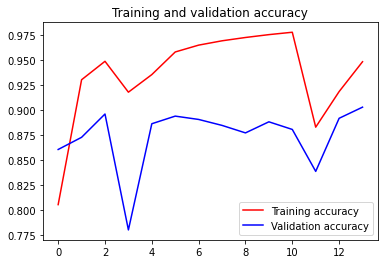

<Figure size 432x288 with 0 Axes>

In [12]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [13]:
model.save('WaferMLP_model.h5')

#### The below code can be run on a different Python file

In [15]:
# Here we load the saved model so that we can use it on out test data

model = tf.keras.models.load_model('WaferMLP_model.h5')
test_dir = os.path.join(base_dir, 'Test')

In [16]:
# We follow the same steps in preparing the test data as we did previousely with the validation data

test_Center_dir = os.path.join(test_dir, 'Center\*.png')
test_Donut_dir = os.path.join(test_dir, 'Donut\*.png')
test_Edge_Loc_dir = os.path.join(test_dir, 'Edge-Loc\*.png')
test_Edge_Ring_dir = os.path.join(test_dir, 'Edge-Ring\*.png')
test_Loc_dir = os.path.join(test_dir, 'Loc\*.png')
test_Near_full_dir = os.path.join(test_dir, 'Near-full\*.png')
test_Random_dir = os.path.join(test_dir, 'Random\*.png')
test_Scratch_dir = os.path.join(test_dir, 'Scratch\*.png')

# Creating Arrays from the test images
Center_test = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(test_Center_dir)])
Donut_test = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(test_Donut_dir)])
Edge_Loc_test = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(test_Edge_Loc_dir)])
Edge_Ring_test = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(test_Edge_Ring_dir)])
Loc_test = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(test_Loc_dir)])
Near_full_test = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(test_Near_full_dir)])
Random_test = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(test_Random_dir)])
Scratch_test = np.asarray([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in glob.glob(test_Scratch_dir)])

test_array = np.concatenate([Center_test, Donut_test, Edge_Loc_test, Edge_Ring_test, 
                             Loc_test, Near_full_test, Random_test, Scratch_test])
test_array = test_array.astype(np.float64)

test_array = test_array/255.0

# Create test labels

test_labels = []

for l in range(num_classes):
    
    for m in range (int(test_array.shape[0]/num_classes)):
        test_labels.append(l)


In [17]:
predictions = model.predict(test_array, batch_size =64)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_labels 

report = metrics.classification_report(true_classes, predicted_classes)
confusion_matrix = metrics.confusion_matrix(true_classes, predicted_classes)

In [18]:
# Print classification report that show different metrics 
print(report) 

              precision    recall  f1-score   support

           0       0.83      0.61      0.70       150
           1       0.99      0.97      0.98       150
           2       0.59      0.72      0.65       150
           3       1.00      0.99      1.00       150
           4       0.48      0.49      0.48       150
           5       0.98      0.86      0.92       150
           6       0.80      0.57      0.67       150
           7       0.65      0.95      0.77       150

    accuracy                           0.77      1200
   macro avg       0.79      0.77      0.77      1200
weighted avg       0.79      0.77      0.77      1200



In [19]:
# Print confusion matrix
print(confusion_matrix)

[[ 91   0  20   0  34   1   2   2]
 [  0 145   1   0   2   0   0   2]
 [  1   0 108   0  35   0   1   5]
 [  0   0   1 149   0   0   0   0]
 [ 14   0  33   0  73   0   0  30]
 [  0   0   5   0   0 129  16   0]
 [  4   1  13   0   6   1  86  39]
 [  0   0   2   0   3   0   2 143]]


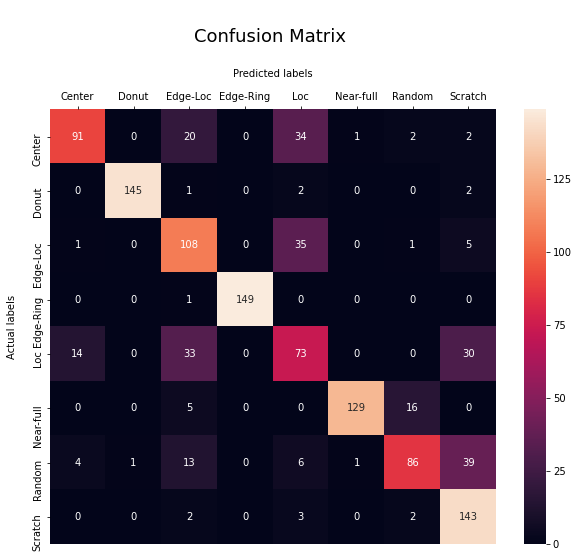

In [20]:
# In this cell we use the seaborn library for better visulaisation of the confusion matrix using heatmap

class_labels = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch']
fig = plt.figure(figsize=(10, 8))
ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True,fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels\n');
ax.xaxis.set_label_position('top') 

ax.set_ylabel('Actual labels\n'); 
ax.set_title('\nConfusion Matrix \n', fontsize=18); 
ax.xaxis.set_ticklabels(class_labels); 
ax.xaxis.tick_top()
ax.yaxis.set_ticklabels(class_labels);
plt.savefig('Confusion_Matrix.png', bbox_inches='tight')

Thank you for attending this tutorial, I hope it was useful. Do not forget to have a look at our paper for more details here:

[An Improved Capsule Network (WaferCaps) for Wafer Bin Map Classification Based on DCGAN Data Upsampling](https://ieeexplore.ieee.org/document/9646243)